<a href="https://akademie.datamics.com/kursliste/">![title](bg_datamics_top.png)</a>

<center><em>© Datamics</em></center><br><center><em>Besuche uns für mehr Informationen auf <a href='https://akademie.datamics.com/kursliste/'>www.akademie.datamics.com</a></em></center>


#### Warnung! Dies ist ein kompliziertes Thema! Denk dran, dieses Notebook ist optional und um es vollständig zu verstehen solltest Du die ergänzenden Quellen in den Links lesen und Dir das komplette Erklärungsvideo anschauen. Dieses Notebook und die Videovorlesungen dienen nicht dazu, ARIMA vollständig zu verstehen, sondern sind eine Übersicht über deren Anwendungen, damit Du später verstehen kannst, warum es (k)eine gute Idee sein könnte, ARIMA für Aktiendaten zu verwenden.
____


# ARIMA und Saisonale ARIMA


## Autoregressive Integrated Moving Averages (gleitende Durchschnitte)

Der grundlegende Prozess für ARIMA-Modelle ist wie folgt:
* Zeitreihendaten visualisieren
* Zeitreihendaten stationär machen
* Korrelations- und AutoKorrelations-Grafiken erstellen
* ARIMA-Modell konstruieren
* Das Modell verwenden, um Vorhersagen zu treffen

Sehen wir uns die einzelnen Schritte an!

## Schritt 1: Datenerfassung (und -formatierung) 

Wir werden Daten zur monatlichen Milchproduktion verwenden. Mehr Details dazu findest Du [hier](https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line).

Die Daten sind bereits als csv für Dich gespeichert. Laden wir sie ein:

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')

In [16]:
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [17]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


** Aufräumen**

Ordnen wir die Daten ein wenig!

In [18]:
df.columns = ['Month','Milk in pounds per cow']
df.head()

,Month,Milk in pounds per cow
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [19]:
# Ein komischer letzter Wert am Ende der Tabelle löst Probleme aus
df.drop(168,axis=0,inplace=True)

In [20]:
df['Month'] = pd.to_datetime(df['Month'])

In [21]:
df.head()

,Month,Milk in pounds per cow
0,1962-01-01,589.0
1,1962-02-01,561.0
2,1962-03-01,640.0
3,1962-04-01,656.0
4,1962-05-01,727.0


In [22]:
df.set_index('Month',inplace=True)

In [23]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [24]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in pounds per cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


## Schritt 2: Daten visualisieren

Visualisieren wir diese Daten mithilfe einiger Methoden.

<AxesSubplot: xlabel='Month'>

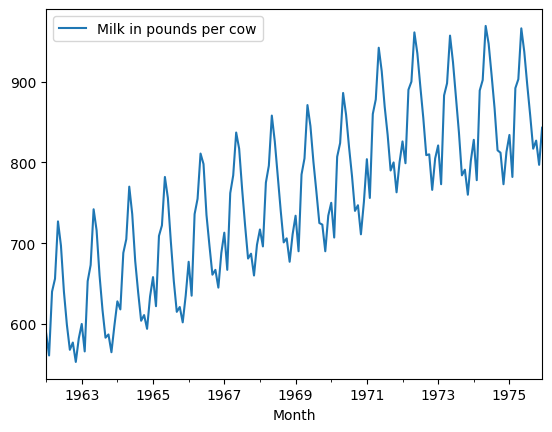

In [25]:
df.plot()

In [26]:
timeseries = df['Milk in pounds per cow']

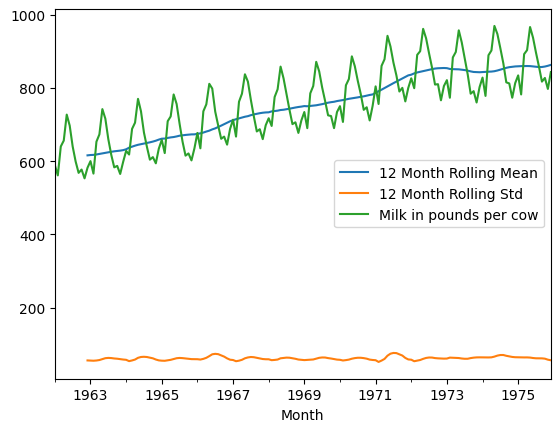

In [27]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean') 
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

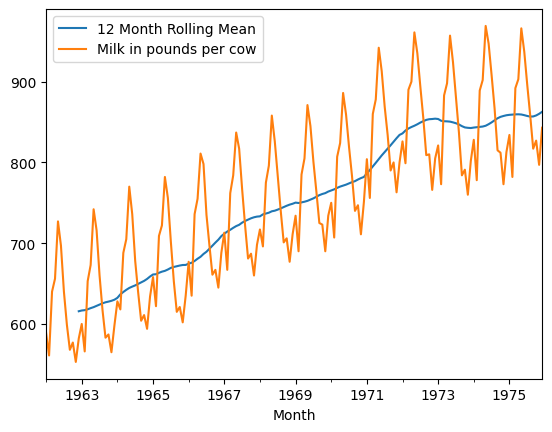

In [28]:
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.plot()
plt.legend()

## Dekomposition

Mithilfe von ETS-Dekomposition können wir die einzelnen Teile sehen! 

<Figure size 640x480 with 0 Axes>

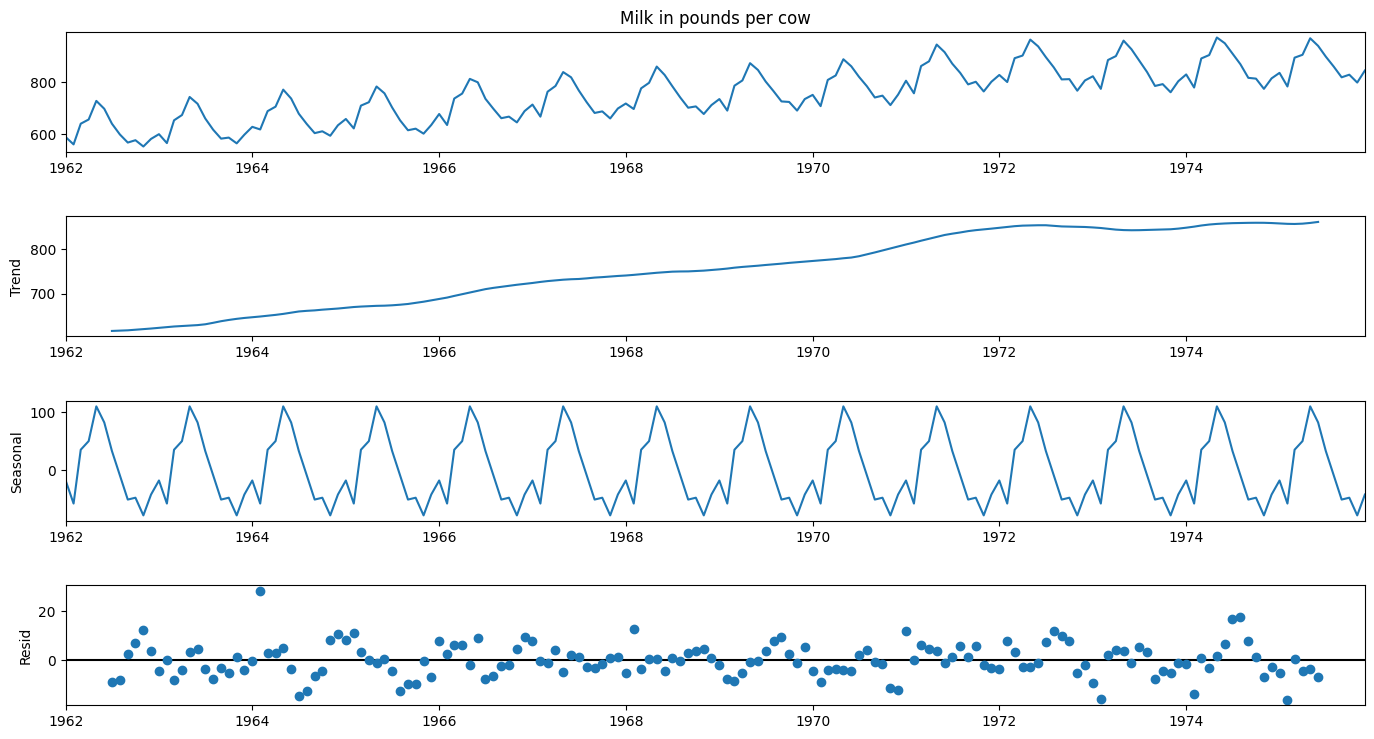

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'])  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

## Auf Stationarität testen

Wir können den erweiterten [Dickey-Fuller](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) [Einheitswurzeltest](https://en.wikipedia.org/wiki/Unit_root_test) nutzen.

In der Statistic und Ökonometrie testet ein erweiterter (augmented) Dickey-Fuller-Test (ADF) die Nullhypothese, dass eine Einheitswurzel (unit root) in einer Stichprobe einer Zeitreihe vorhanden ist. Die Alternativhypothese unterscheidet sich, je nachdem, welche Version des Tests verwendet wird; normalerweise ist sie Stationarität oder Trend-Stationarität.

Wir versuchen herauszufinden, ob wir die Nullhypothese **H0** (dass die Zeitreihe eine Einheitswurzel besitzt, also dass sie nicht-stationär ist) annehmen oder ablehnen und stattdessen die Alternativhypothese annehmen (dass die Zeitreihe keine Einheitswurzel hat und stationär ist).

Wir werden das letztendlich aufgrund des zurückgegebenen p-Werts entscheiden.

* Ein kleiner p-Wert (üblicherweise ≤ 0.05) ist ein starker Beweis gegen die Nullhypothese, also lehnen wir sie ab.

* Ein großer p-Wert (> 0.05) ist ein schwacher Beweis gegen die Nullhypothese, also können wir sie nicht ablehnen.

Führen wir den erweiterten Dickey-Fuller-Test für unsere Daten aus:

In [36]:
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


In [37]:
from statsmodels.tsa.stattools import adfuller

In [38]:
result = adfuller(df['Milk in pounds per cow'])

In [39]:
print('Augmented Dickey-Fuller Test:')
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

for value,label in zip(result,labels):
    print(label+' : '+str(value) )
    
if result[1] <= 0.05:
    print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
else:
    print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.303811587422122
p-value : 0.627426708603035
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [40]:
# In einer Funktion für die spätere Nutzung speichern!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

___________

## Wichtiger Hinweis!

** Wir haben jetzt festgestellt, dass unsere Daten saisonal sind (was auch schon am Diagramm selbst sehr deutlich geworden ist). Das heißt, dass wir für unser Modell saisonale ARIMA verwenden müssen. Wären unsere Daten nicht saisonal, könnten wir einfache ARIMA nutzen. Das werden wir berücksichtigen, wenn wir unsere Daten differenzieren! Typische Aktiendaten sind nicht saisonal, aber genau das ist der Sinn dieses Abschnitts: Dir verbreitete Methoden zu zeigen, die nicht gut mit Aktiendaten funktionieren werden!**

_____

## Differenzierung

Die erste Differenz bei einer Zeireihe ist die Veränderungsserie von einer Periode zur nächsten. Das können wir einfach mit Pandas machen. Du kannst dann mit der zweiten Differenz, der dritten Differenz usw. so weitermachen, bis Deine Daten stationär sind.

** Erste Differenz **

In [43]:
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)

In [44]:
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530677
p-value : 0.03006800400178584
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot: xlabel='Month'>

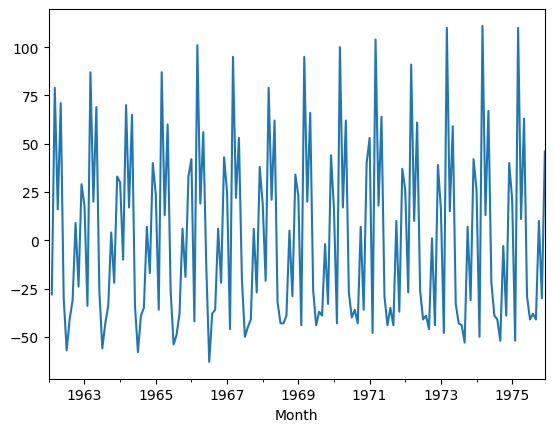

In [45]:
df['Milk First Difference'].plot()

**Zweite Differenz** - wird gebraucht, wenn die erste Differenz immer noch nicht stationär sein sollte

In [46]:
# Manchmal ist es notwendig, eine zweite Differenz zu bilden
# Dies ist nur zur Demonstration, wir mussten in unserem Fall keine zweite Differenz bilden
df['Milk Second Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(1)

In [47]:
adf_check(df['Milk Second Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -14.327873645603376
p-value : 1.112698933208163e-26
#Lags Used : 11
Number of Observations Used : 154
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


<AxesSubplot: xlabel='Month'>

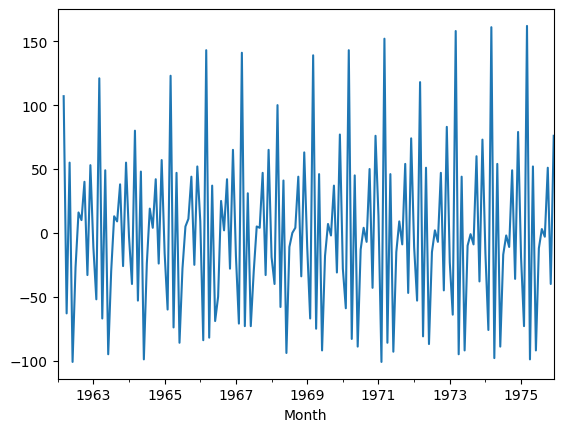

In [48]:
df['Milk Second Difference'].plot()

**Saisonale Differenz** - also jährlich (12 Monate)

<AxesSubplot: xlabel='Month'>

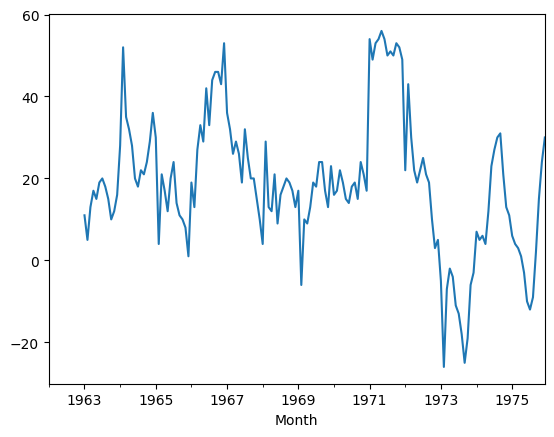

In [50]:
df['Seasonal Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(12)
df['Seasonal Difference'].plot()

In [51]:
# Saisonale Differenz an sich war nicht genug!
adf_check(df['Seasonal Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -2.335419314359398
p-value : 0.1607988052771135
#Lags Used : 12
Number of Observations Used : 143
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


**Saisonale Erste Differenz**

<AxesSubplot: xlabel='Month'>

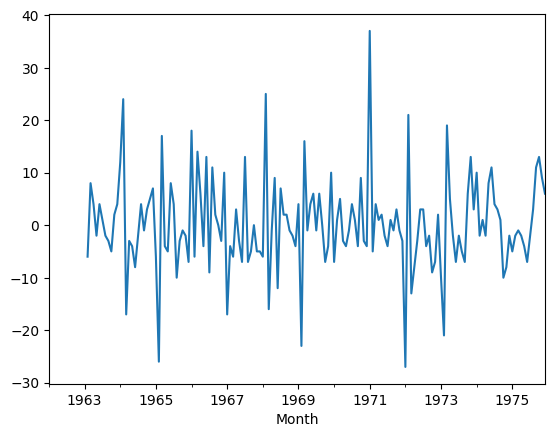

In [54]:
# Du kannst auch die saisonale erste Differenz bilden
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot()

In [53]:
adf_check(df['Seasonal First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.0380022749219675
p-value : 1.8654234318789772e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


# Autokorrelations- und Teil(Partial)-Autokorrelationsdiagramme

Ein Autokorrelationsdiagramm (auch [Korrelogramm](https://en.wikipedia.org/wiki/Korrelogramm)) zeigt die Korrelation der Reihe mit sich selbst, um x Zeiteinheiten verschoben. Auf der y-Achse steht die Korrelation und auf der x-Achse die Anzahl der Zeiteinheiten, um die verschoben wurde.

Stell Dir also vor, Du nimmst Deine Zeitreihe der Länge T, kopierst sie und löschst die erste Beobachtung der Kopie #1 und die letzte Beobachtung der Kopie #2. Jetzt hast Du zwei Zeitreihen der Länge T-1, für die du einen Korrelationskoeffizienten berechnen kannst. Dies ist der Wert der vertikalen Achse bei x=1 in Deinen Diagrammen. Er stellt die Korrelation deiner Zeitreihe, verschoben um eine Zeiteinheit, dar. Du machst so weiter für alle möglichen Zeitverschiebungen x. Dies definiert dann Dein Diagramm.

Du wirst diese Diagramme auf deine differenzierten/stationären Daten anwenden. Es gibt eine Menge sehr guter Informationen zur Identifikation und Interpretation von ACF und PACF [hier](http://people.duke.edu/~rnau/arimrule.htm) und [hier](https://people.duke.edu/~rnau/411arim3.htm).

### Interpretation der Autokorrelation 

Die eigentliche Interpretation und wie sie mit ARIMA-Modellen in Verbindung steht, kann ein bisschen kompliziert werden, aber es gibt ein paar übliche Methoden, die wir für das ARIMA-Modell verwenden können. Unsere höchste Priorität hier ist es, herauszufinden ob wir die AR- oder die MA-Komponenten des ARIMA-Modells (oder beide!) verwenden, und wie viele Verschiebungen wir benutzen sollen. Im Allgemeinen würde man entweder AR oder MA verwenden; beides zusammen ist eher weniger üblich.

* Wenn das Autokorrelationsdiagramm eine positive Autokorrelation bei der ersten Verschiebung (lag-1) zeigt, deutet das darauf hin, dass die AR-Terme in Bezug auf die Verschiebung verwendet werden sollte.
* Falls das Autokorrelationsdiagramm eine negative Autokorrelation bei der ersten Verschiebung zeigt, sollten die MA-Terme verwendet werden.

_____
### <font color='red'> Wichtiger Hinweis! </font> 

Hier werden wir zeigen, wie man ACF und PACF auf mehrere differenzierte Datensätze anwendet, die auf verschiedene Arten stationär gemacht wurden. Typischerweise würdest würdest Du Dir einfach einen einzelnen stationären Datensatz aussuchen und mit diesem fortfahren.

Der Grund, warum wir hier zwei verwenden ist, um Dir zwei typische Arten von Verhalten zu zeigen, das wir sehen können, wenn wir ACF benutzen.
_____

In [56]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

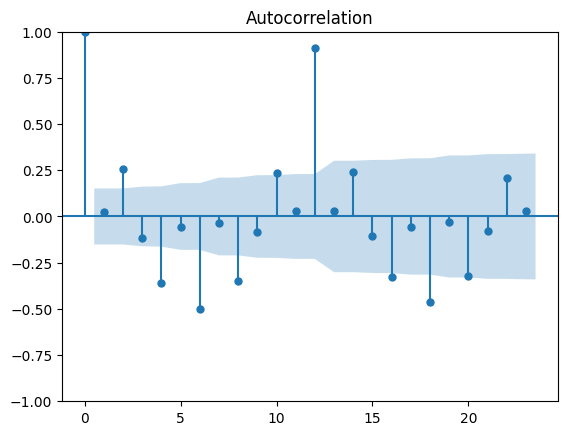

In [57]:
# Diagramme verdoppeln
# Zum Nachsehen: https://stackoverflow.com/questions/21788593/statsmodels-duplicate-charts
# https://github.com/statsmodels/statsmodels/issues/1265
fig_first = plot_acf(df["Milk First Difference"].dropna())

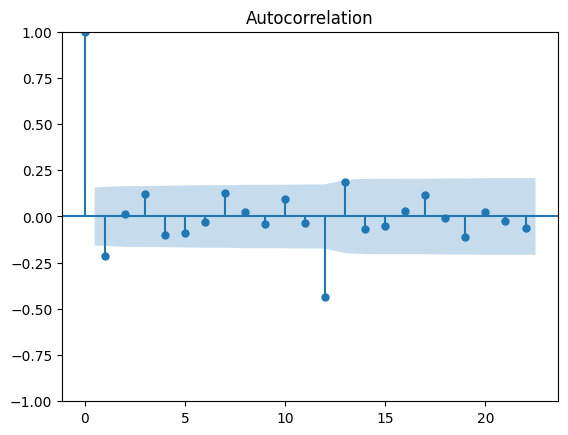

In [58]:
fig_seasonal_first = plot_acf(df["Seasonal First Difference"].dropna()) #use_vlines=False

Pandas hat diese Funktionalität ebenfalls eingebaut, aber nur für ACF, nicht für PACF. Daher empfehlen wir, statsmodels zu verwenden, da ACF und PACF näher an dessen Funktionalität liegen als an der von Pandas.

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

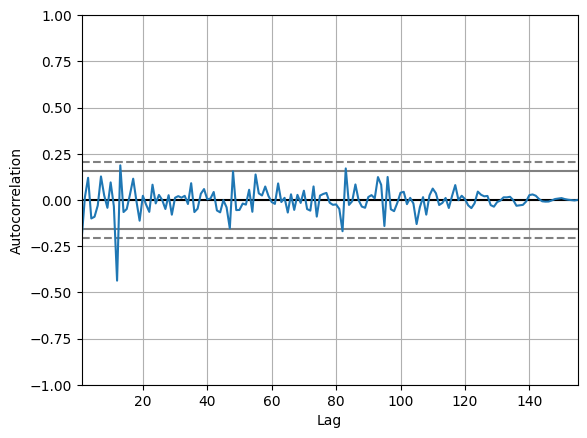

In [60]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Teil-Autokorrelation

Im Allgemeinen ist eine Teil-Autokorrelation eine bedingte Korrelation.

Es ist die Korrelation zwischen zwei Variablen unter der Annahme, dass wir die Werte einiger anderer Variablensätze kennen und berücksichtigen.

Zum Beispiel: stell Dir einen Regressionskontext vor, in dem y eine Antwortvariable und x1, x2, x3 Prädiktorvariablen sind. Die Teilkorrelation zwischen y und x3 ist die Korrelation zwischen den Variablen, die unter Berücksichtigung der Relationen von y und x3 zu x1 und x2 bestimmt wurde.

Formal ist diese Beziehung definiert als:

## $\frac{\text{Kovarianz}(y, x_3|x_1, x_2)}{\sqrt{\text{Varianz}(y|x_1, x_2)\text{Varianz}(x_3| x_1, x_2)}}$

Sieh dir diesen [Link](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4463.htm) für mehr Details dazu an.

Diese Beziehung können wir grafisch darstellen:

/Users/frederik/opt/anaconda3/envs/Depot/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


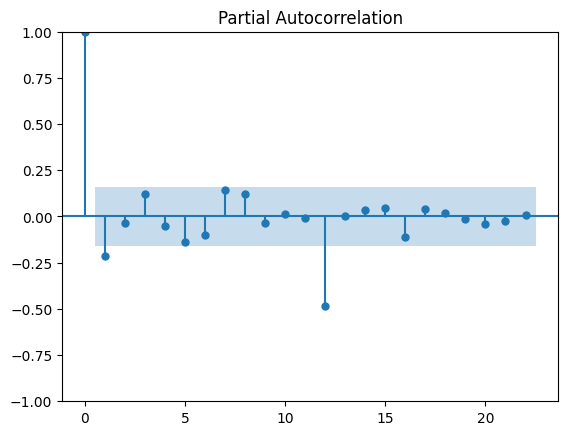

In [61]:
result = plot_pacf(df["Seasonal First Difference"].dropna())

### Interpretation

Typischerweise bedeutet ein scharfer Abfall nach "k" Verzögerungen, dass ein AR-k Modell verwendet werden sollte. Falls es einen langsamen Abfall gibt, sollte ein MA-Modell verwendet werden.

### Abschließende Gedanken zu Autokorrelation und Teil-Autokorrelation

* Die Identifizierung eines AR-Modells wird oft am besten mit dem PACF durchgeführt.
    * Für ein AR-Model wird der theoretische PACF nach der Ordnung des Modells "abgeschaltet" (“shut off”). Der Ausdruck "abgeschaltet" heißt, dass die Teilautokorrelationen ab diesem Punkt theoretisch 0 sind. Anders gesagt, die Anzahl der Teilautokorrelationen, die nicht 0 sind, bestimmt die Ordnung des AR-Modells. Mit "Ordnung des Modells" ist die extremste Verzögerung von x gemeint, die als Prädiktor verwendet wird.
    
* Die Identifizierung eines MA-Modells wird oft am besten mit dem ACF statt mit dem PACF durchgeführt.
    * Für ein MA-Modell wird der theoretische PACF nicht abgeschaltet, sondern nimmt auf irgendeine Art und Weise Richtung 0 ab. Ein deutlicheres Muster für ein MA-Modell liegt im ACF. Der ACF wird nur bei solchen Verzögerungen nicht 0 sein, die in das Modell eingebunden sind.

_____
### Abschließende ACF- und PACF-Diagramme

Wir haben bereits einige Diagramme erstellt, also schauen wir uns nur noch schnell die "finalen" ACF- und PACF-Diagramme an. Auf diese werden wir uns im Rest des Notebooks unten beziehen.
_____

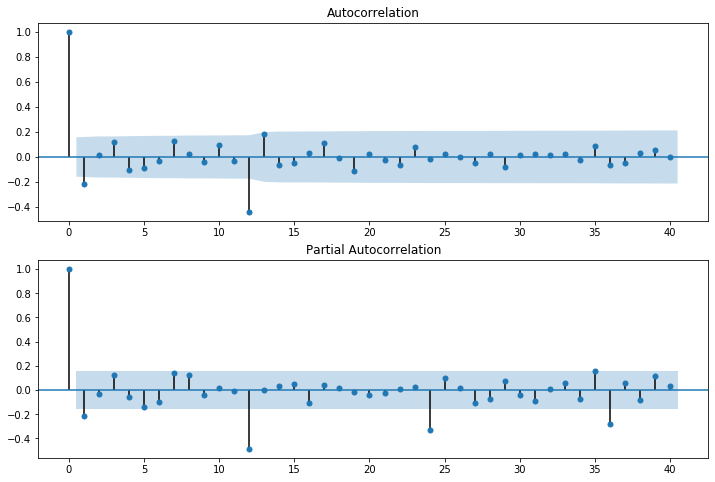

In [37]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Seasonal First Difference'].iloc[13:], lags=40, ax=ax2)

## Das Saisonale ARIMA-Modell benutzen

Nun, da wir ein Verständnis für unsere Daten bekommen haben,können wir endlich unser ARIMA-Modell anwenden!

In [62]:
# Für nicht-saisonale Daten
from statsmodels.tsa.arima_model import ARIMA

In [63]:
# Wir empfehlen Dir, das einmal anzusehen!

# 
help(ARIMA)

Help on class ARIMA in module statsmodels.tsa.arima_model:

class ARIMA(ARMA)
 |  ARIMA(*args, **kwargs)
 |  
 |  ARIMA has been deprecated in favor of the new implementation
 |  
 |  See Also
 |  --------
 |  statsmodels.tsa.arima.model.ARIMA
 |      ARIMA models with a variety of parameter estimators
 |  statsmodels.tsa.statespace.SARIMAX
 |      SARIMAX models estimated using MLE
 |  
 |  Method resolution order:
 |      ARIMA
 |      ARMA
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from ARMA:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



### p,d,q Parameter

* p: Anzahl der Verzögerungsbeobachtungen, die in dem Modell berücksichtigt wurden.
* d: Anzahl der Differenzierungen der Rohdaten, auch Grad der Differenzierung.
* q: Größe des Fensters des gleitenden Durchschnitts (moving average window), auch Ordnung (order) des gleitenden Durchschnitts.

In [64]:
# Wir haben saisonale Daten!
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

/Users/frederik/opt/anaconda3/envs/Depot/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/frederik/opt/anaconda3/envs/Depot/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.18877D+00    |proj g|=  7.76704D-02

At iterate    5    f=  3.17904D+00    |proj g|=  6.55291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.116D-06   3.179D+00
  F =   3.1789606817876526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                      SARIMAX Results                                       
Dep. Variable:               Milk in po

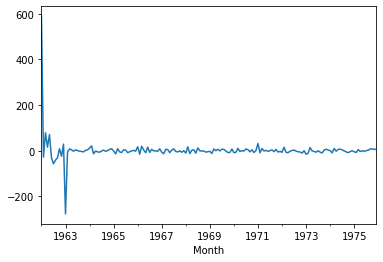

In [41]:
# Difference between the predicted value of the model and the true value (training-data)
results.resid.plot()

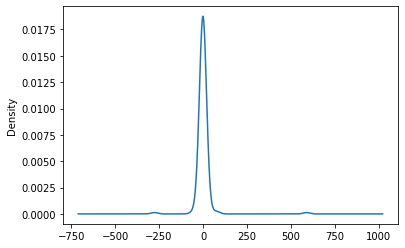

In [42]:
# Same but as density plot of residuals
results.resid.plot(kind='kde')

## Vorhersage zukünftiger Werte

Zuerst können wir uns einen Eindruck davon verschaffen, wie gut unser Modell funktioniert, indem wir einfach Werte vorhersagen, die wir bereits kennen:

<AxesSubplot: xlabel='Month'>

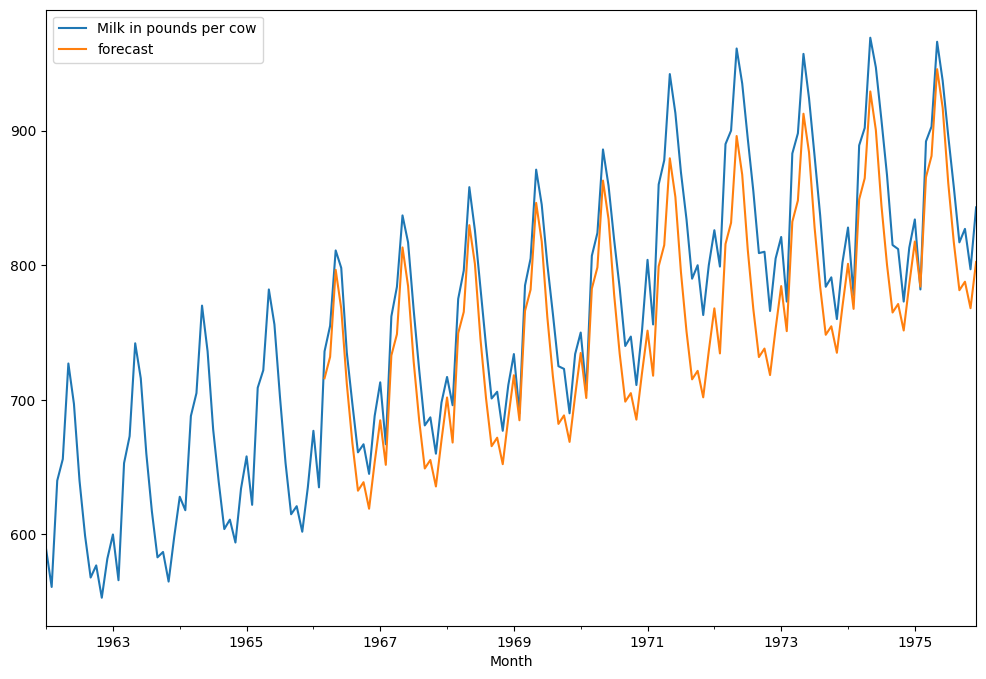

In [66]:
df['forecast'] = results.predict(start=50, end=168, dynamic=True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

### Vorhersagen
Dies erfordert mehr Zeitperioden, also erstellen wir sie mit Pandas in unserem ursprünglichen Datenframe.

In [67]:
df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
Month,,,,,,
1975-08-01,858.0,-38.0,3.0,-9.0,3.0,816.953109
1975-09-01,817.0,-41.0,-3.0,2.0,11.0,781.433503
1975-10-01,827.0,10.0,51.0,15.0,13.0,787.749521
1975-11-01,797.0,-30.0,-40.0,24.0,9.0,768.080189
1975-12-01,843.0,46.0,76.0,30.0,6.0,802.447040


In [45]:
# https://pandas.pydata.org/pandas-docs/stable/timeseries.html
# Alternativen 
# pd.date_range(df.index[-1],periods=12,freq='M')

In [68]:
from pandas.tseries.offsets import DateOffset

In [69]:
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]

In [70]:
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [71]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [72]:
future_df = pd.concat([df,future_dates_df])

In [73]:
future_df.head()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1962-01-01,589.0,NaN,NaN,NaN,NaN,NaN
1962-02-01,561.0,-28.0,NaN,NaN,NaN,NaN
1962-03-01,640.0,79.0,107.0,NaN,NaN,NaN
1962-04-01,656.0,16.0,-63.0,NaN,NaN,NaN
1962-05-01,727.0,71.0,55.0,NaN,NaN,NaN


In [74]:
future_df.tail()

,Milk in pounds per cow,Milk First Difference,Milk Second Difference,Seasonal Difference,Seasonal First Difference,forecast
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot: >

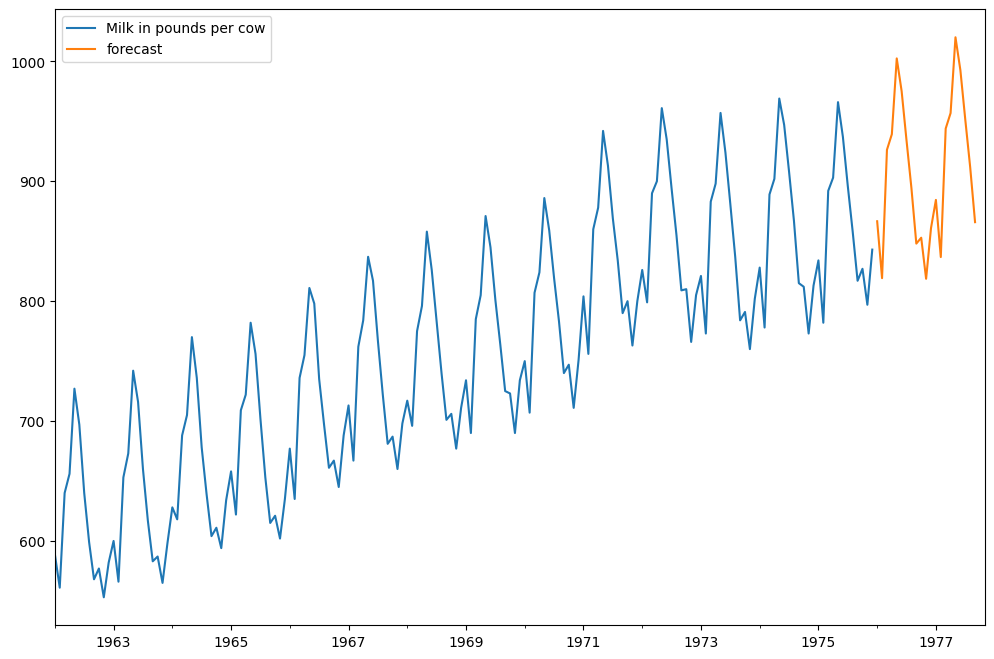

In [75]:
future_df['forecast'] = results.predict(start=168, end=188, dynamic=True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8)) 

Nicht schlecht! Sogar ziemlich cool! Wir hoffen, dass Dir das dabei geholfen hat, das Potenzial von ARIMA-Modellen zu erkennen. Unglücklicherweise werden viele Finanzdaten nicht diesem Verhalten entsprechen. Tatsächlich werden sie oft etwas folgen, das auf Brownsche Bewegung hindeutet. Was das ist? Mach einfach weiter mit der nächsten Videolektion und wir finden es heraus!

# Großartig!